# Fisher Forecasts for Simons Observatory 

The fisher matrix is defined as 
 
$$
F_{ij} = \sum_l \frac{2\ell+1}{2} f_{\rm sky} \text{Tr}\left( \mathbb{C}_\ell^{-1} \frac{\partial \mathbf{C}_\ell}{\partial \theta_i} \mathbb{C}_\ell^{-1} \frac{\partial \mathbf{C}_\ell}{\partial \theta_j} \right)
$$

where $f_{\rm sky}$ is the fractional sky coverage of our chosen experiment, $\theta_i$ and $\theta_j$ are the cosmological parameters for which we want to estimate the errors, $\mathbf{C}_\ell$ is a 2x2 matrix of CMB power spectra defined as

$$
\mathbf{C}_\ell = 

\begin{pmatrix}
    C_\ell^{TT} & C_\ell^{TE} \\
    C_\ell^{TE} & C_\ell^{EE}
\end{pmatrix}, 
$$

and $\mathbb{C}_\ell$ is the covariance matrix which accounts for noise in each observable. The covariance is defined as

$$
\mathbb{C}_\ell = 
\begin{pmatrix}
    C_\ell^{TT}+N_\ell^{TT} & C_\ell^{TE} \\
    C_\ell^{TE} & C_\ell^{EE} + N_\ell^{EE}
\end{pmatrix}. 
$$

where the $N_\ell$'s correspond to the experimental noise curves, determined by the experiment you want to run forecasts for.

For SO, we can generate the noise curves using the so_noise_models code: https://github.com/simonsobs/so_noise_models/tree/master. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from so_noise_models.so_models_v3 import SO_Noise_Calculator_Public_v3_1_2 as so_models

import itertools
import pickle

import astropy.units as u
from scipy.interpolate import interp1d as i1d

In [2]:
def save_in_file(name, lis, header):
    '''
    Save the list (i.e. [k, Pk, sk]) in a file with path 'name'
    Arguments: name = <path>, lis = <what to save>
    '''
    LEN = len(lis[0])
    lenlis = len(lis)
    for i in range(1, lenlis):
        if len(lis[i]) != LEN:
            raise Exception('ALL items in the list to save MUST be 1d arrays with the same length!')
    
    MAT = np.zeros((LEN,lenlis))
    for i in range(0,lenlis):
        MAT[:,i] = lis[i]

    np.savetxt(name,MAT,header=header)
    return

def save_obj(obj, name ):
    '''
    Saves the object (generally a list) using pickle
    '''
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Initialize

Define the parameters for the experiment/observation to get correct noise curves. Specify the parameters of the Fisher forecast and combine everything into a dictionary to call CLASS to generate the $C_\ell$'s.

If a parameter is defined in CLASS, it can be included in the Fisher matrix. Example here is shown for $\Lambda$-CDM+$N_{eff}$. 

In [ ]:
def define_params(): 
    ''' Defines parameters for SO, fisher forecast, and CLASS. 
    Noise Types (defined in https://arxiv.org/pdf/1808.07445):
        0 - standard ILC
        1 - tSZ deprojection
        2 - Fiducial CIB SED deprojection
        3 - tSZ + CIB SED deprojection
    '''

    obs_params = {
        'fsky':0.4, # fraction of the sky observed
        'sensitivity': 1, # 0 for threshold, 1 for baseline, 2 for goal (defined in https://arxiv.org/pdf/1808.07445)
        'elevation': 50., # elevation of the telescope over the horizon in degrees, must be between 1 and 90.
        'noise_type': 0
    }

    # Parameters for Fisher forecast
    pars = np.array( ['omega_b', 'omega_cdm', 'H0',  'A_s', 'n_s', 'tau_reio'])
    centers = np.array([0.02237,  0.1200,  67.36,  2.100e-9, 0.9649, 0.0544])
    half_steps = np.array([0.000025, 0.00035,   0.15,   0.015e-9, 0.001, 0.0035]) # \Delta\theta_i

    pars_dict = dict(zip(pars, centers))
    steps_dict = dict(zip(pars, half_steps))

    # Parameters for CLASS
    class_params = {
            'output':'tCl,lCl,pCl',
            # 'theta_s_100': pars_dict['theta_s_100'],
            'H0': pars_dict['H0'],
            'omega_b': pars_dict['omega_b'],   
            'omega_cdm': pars_dict['omega_cdm'],  
            'A_s': pars_dict['A_s'],
            'n_s': pars_dict['n_s'],
            'tau_reio': pars_dict['tau_reio'],
            'N_eff': 3.046,
            'YHe':'BBN',
            'l_max_scalars':3000,
            'lensing':'yes',
            'gauge':'synchronous'}

    return pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params

### Generate fiducial $C_\ell$'s and derivatives with respect to all parameters

The derivatives are defined numerically such that

$$
\frac{\partial C_\ell}{\partial \theta_i} = \frac{C_\ell(\theta_i + \Delta\theta_i) - C_\ell(\theta_i - \Delta\theta_i)}{2*\Delta\theta_i},
$$

where $\Delta\theta_i$ is defined by the half_steps parameter. 

In [3]:
def get_Cls(params):
    ''' returns the Cl's for TT, TE, and EE in micro K^2 '''
    M = Class()
    M.set(params)
    M.compute()

    ell_max = params['l_max_scalars']

    ell = M.lensed_cl(ell_max)['ell'][2:]
    Cl_tt = M.lensed_cl(ell_max)['tt'][2:]*(M.T_cmb()*1e6)**2
    Cl_te = M.lensed_cl(ell_max)['te'][2:]*(M.T_cmb()*1e6)**2
    Cl_ee = M.lensed_cl(ell_max)['ee'][2:]*(M.T_cmb()*1e6)**2

    return ell, Cl_tt, Cl_te, Cl_ee

def compute_Cl_derivs(param):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()

    new_params = class_params.copy()

    new_params[param] -= steps_dict[param]
    ell, left_Cl_tt, left_Cl_te, left_Cl_ee = get_Cls(new_params)

    new_params[param] += steps_dict[param]
    new_params[param] += steps_dict[param] # avoids floating point errors
    ell, right_Cl_tt, right_Cl_te, right_Cl_ee = get_Cls(new_params)

    new_params[param] -= steps_dict[param] # reset the parameter, just in case

    dCl_tt = (right_Cl_tt - left_Cl_tt)/(2*steps_dict[param])
    dCl_te = (right_Cl_te - left_Cl_te)/(2*steps_dict[param])
    dCl_ee = (right_Cl_ee - left_Cl_ee)/(2*steps_dict[param])

    return ell, dCl_tt, dCl_te, dCl_ee

def get_derivs(name):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()

    ell_max = class_params['l_max_scalars']

    print('Computing fiducial Cls')
    ell, fid_Cl_tt, fid_Cl_te, fid_Cl_ee = get_Cls(class_params)
    save_in_file('output/'+name+'_fiducial_Cls.txt', [ell, fid_Cl_tt, fid_Cl_te, fid_Cl_ee], 'ell, fid_Cl_tt, fid_Cl_te, fid_Cl_ee')

    for par in pars:
        print('Computing derivatives for parameter:', par)
        filename = 'output/'+name+'_Cl_derivs_'+par+'.txt'
        ell, dCl_tt, dCl_te, dCl_ee = compute_Cl_derivs(par)
        save_in_file(filename, [ell, dCl_tt, dCl_te, dCl_ee], 'ell, dCl_tt, dCl_te, dCl_ee')

### Generate Noise Curves 

In [4]:
def get_noise_curves(ell_max):
# def get_noise_curves(mode,fsky,ell_max,el):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()
    mode = obs_params['sensitivity']
    fsky = obs_params['fsky']
    el = obs_params['elevation']

    lat = so_models.SOLatV3point1(mode, el=el)
    corr_pairs = [(0,1),(2,3),(4,5)]

    bands = lat.get_bands()
    print("band centers: ", lat.get_bands(), "[GHz]")
    print("beam sizes: "  , lat.get_beams(), "[arcmin]")
    N_bands = len(bands)

    ell, N_ell_LA_T_full,N_ell_LA_P_full = lat.get_noise_curves(
        fsky, ell_max, 1, full_covar=True, deconv_beam=True)

    WN_levels = lat.get_white_noise(fsky)**.5

    N_ell_LA_T  = N_ell_LA_T_full[range(N_bands),range(N_bands)]
    N_ell_LA_Tx = [N_ell_LA_T_full[i,j] for i,j in corr_pairs]
    N_ell_LA_P  = N_ell_LA_P_full[range(N_bands),range(N_bands)]
    N_ell_LA_Px = [N_ell_LA_P_full[i,j] for i,j in corr_pairs]

    print("white noise levels: "  , WN_levels, "[uK-arcmin]")

    return ell, N_ell_LA_T, N_ell_LA_Tx, N_ell_LA_P, N_ell_LA_Px

def plot_temperature_noise():
    ell, N_ell_LA_T, N_ell_LA_Tx, N_ell_LA_P, N_ell_LA_Px = get_noise_curves(3000)

    bands = so_models.SOLatV3point1(1, el=50).get_bands()
    corr_pairs = [(0,1),(2,3),(4,5)]

    plt.figure()
    for i in range(len(N_ell_LA_T)):
        plt.semilogy(ell,N_ell_LA_T[i], label='%i GHz' % (bands[i]), ls='-', lw=2.)

    corr_pairs = ['27 x 39', '93 x 145', '225 x 280']
    for i in range(len(corr_pairs)):
        plt.semilogy(ell,N_ell_LA_Tx[i], label='%s GHz' % (corr_pairs[i]), ls='-', lw=2.)

    plt.title(r"$N(\ell$) Temperature", fontsize=18)
    plt.ylabel(r"$N(\ell$) [$\mu$K${}^2$]", fontsize=16)
    plt.xlabel(r"$\ell$", fontsize=16)
    plt.ylim(5e-7,1e0)
    plt.xlim(2,3000)
    plt.legend(loc='lower left', ncol=2, fontsize=8)
    plt.grid()

def naive_noise_curve(ell): 
    '''
    This naive curve gives the same curve as the 93 GHz SO noise calculator. Don't quite know how to
    add the noise curves from so_noise_models at different frequencies together. Also need to add in the 
    Planck noise curves for completion.

    Parameters taken from Table 1 and 2 of https://arxiv.org/pdf/1808.07445. 
    '''
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()

    arcmin = 0.000291 # rad
    Delta_T = 8.0*u.uK*arcmin
    theta_FWHM = 2.2*arcmin
    # Nred = 1800*u.uK**2*u.s 
    Nred = 230/2*u.uK**2*u.s #factor of 2 is for FOV modification?
    ell_knee = 1000
    alpha_knee = -3.5
    tobs = 157680000*u.s*0.2*0.85

    Nwhite = Delta_T.value**2*np.exp( ell*(ell+1)*theta_FWHM**2/(8*np.log(2)) ) # unit is uK^2
    
    Natm = (Nred*(4*np.pi*obs_params['fsky'])/tobs ).value # unit is uK^2
    Natm *= (ell/ell_knee)**alpha_knee
    Natm *= np.exp(ell*(ell+1)*theta_FWHM**2/(8*np.log(2)))

    Nell = Nwhite + Natm

    return np.array(Nell)*u.uK**2

def comp_sep_noise_curves():
    '''
    Load in the ILC post-component separation noise curves. Includes baseline and goal sensitivities. 
    Each deprojection is explained in Sec, 2.5.1-2.5.3 of https://arxiv.org/pdf/1808.07445.
    '''
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()

    if obs_params['fsky'] != 0.4: raise Exception('f_sky must be 0.4 for the SO noise curves')

    if obs_params['sensitivity'] == 1: # baseline
        T_filename = 'so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_baseline_fsky0p4_ILC_CMB.txt'
        ell_T, Deproj0_T, Deproj1_T, Deproj2_T, Deproj3_T  = np.loadtxt(T_filename).T

        P_filename = 'so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_P_baseline_fsky0p4_ILC_CMB_E.txt'
        ell_P, Deproj0_P, Deproj1_P, Deproj2_P, Deproj3_P  = np.loadtxt(P_filename).T
    
    elif obs_params['sensitivity'] == 2: # goal
        T_filename = 'so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt'
        ell_T, Deproj0_T, Deproj1_T, Deproj2_T, Deproj3_T  = np.loadtxt(T_filename).T

        P_filename = 'so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_P_goal_fsky0p4_ILC_CMB_E.txt'
        ell_P, Deproj0_P, Deproj1_P, Deproj2_P, Deproj3_P  = np.loadtxt(P_filename).T
    
    if obs_params['noise_type'] == 0: N_ell_T, N_ell_P = Deproj0_T, Deproj0_P   
    elif obs_params['noise_type'] == 1: N_ell_T, N_ell_P = Deproj1_T, Deproj1_P   
    elif obs_params['noise_type'] == 2: N_ell_T, N_ell_P = Deproj2_T, Deproj2_P   
    elif obs_params['noise_type'] == 3: N_ell_T, N_ell_P = Deproj3_T, Deproj3_P   

    return ell_T, N_ell_T, ell_P, N_ell_P

### Compute Fisher Matrix

In [5]:
def cov_dict(name):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()
    ell, fid_Cl_tt, fid_Cl_te, fid_Cl_ee = np.loadtxt('output/'+name+'_fiducial_Cls.txt').T   

    # component separated noise curves (Sec. 2.5.2 of https://arxiv.org/pdf/1808.07445, plotted in Table 5)
    ell_T, N_ell_T, ell_P, N_ell_P = comp_sep_noise_curves()
    # interpolate to same format as fiducial Cls
    Nell_tt = i1d(ell_T, N_ell_T,kind='cubic',bounds_error=False,fill_value='extrapolate')(ell)
    Nell_ee = i1d(ell_P, N_ell_P,kind='cubic',bounds_error=False,fill_value='extrapolate')(ell)

    fid = {'tt': fid_Cl_tt, 'te': fid_Cl_te, 'ee': fid_Cl_ee}
    noise = {'tt': Nell_tt , 'ee': Nell_ee} 

    return ell, fid, noise

def derivs(ell,name):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()
    ell_max = class_params['l_max_scalars']

    derivs = { 
        par: { 
            'tt': np.zeros(len(ell)), 
            'te': np.zeros(len(ell)), 
            'ee': np.zeros(len(ell)) 
        } for par in pars 
    }

    for par in pars:
        filename = 'output/'+name+'_Cl_derivs_'+par+'.txt'
        ell, dCl_tt, dCl_te, dCl_ee = np.loadtxt(filename).T  

        derivs[par]['tt'] = dCl_tt
        derivs[par]['te'] = dCl_te
        derivs[par]['ee'] = dCl_ee 
    
    return derivs


def compute_fisher_matrix(name):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()
    ell, fid, noise = cov_dict(name)
    drvs = derivs(ell,name)

    l_min, l_max = int(ell[0]), int(ell[-1])
    Npar = len(pars)
    fisher = np.zeros((Npar,Npar))
    
    for i,j in itertools.combinations_with_replacement(range(Npar), r=2):
        # Follows Eq. 8.20-21 of https://arxiv.org/pdf/1610.02743 or Eq. 4 of https://arxiv.org/pdf/1402.4108.pdf
        # F_ij = 0.5 * Tr[C^-1 dC_i C^-1 dC_j]
        fisher_ij = 0.0
        for l in range(l_min, l_max-1):
            # cov and inv_cov are 2 x 2 matrices defined at each ell
            cov_l = np.array([[fid['tt'][l] + noise['tt'][l], fid['te'][l]],
                                [fid['te'][l], fid['ee'][l] + noise['ee'][l]]])
            inv_cov_l = np.linalg.inv(cov_l)

            dCl_i = np.array([[drvs[pars[i]]['tt'][l], drvs[pars[i]]['te'][l]],
                            [drvs[pars[i]]['te'][l], drvs[pars[i]]['ee'][l]]])
            dCl_j = np.array([[drvs[pars[j]]['tt'][l], drvs[pars[j]]['te'][l]],
                            [drvs[pars[j]]['te'][l], drvs[pars[j]]['ee'][l]]])

            deriv_term = np.dot(np.dot(inv_cov_l, dCl_i), np.dot(inv_cov_l, dCl_j))
            fisher_contrib = (2*l+1)/2. * obs_params['fsky'] * np.trace(deriv_term)

            # F_ij is a sum over all ell, so we iteratively add each contribution
            fisher_ij += fisher_contrib

        # fisher is diagonal
        fisher[i, j] = fisher_ij
        fisher[j, i] = fisher_ij  
    
    save_obj(fisher,'output/'+name+'_fisher')
    return fisher

def load_fisher(name):
    with open('output/'+name+'_fisher.pkl', 'rb') as f:
        fisher = pickle.load(f)
    return fisher


### Make Fishers

In [6]:
def define_params(): 
    ''' Defines parameters for SO, fisher forecast, and CLASS. 
    Noise Types (defined in https://arxiv.org/pdf/1808.07445):
        0 - standard ILC
        1 - tSZ deprojection
        2 - Fiducial CIB SED deprojection
        3 - tSZ + CIB SED deprojection
    '''

    obs_params = {
        'fsky':0.4, # fraction of the sky observed
        'sensitivity': 1, # 0 for threshold, 1 for baseline, 2 for goal (defined in https://arxiv.org/pdf/1808.07445)
        'elevation': 50., # elevation of the telescope over the horizon in degrees, must be between 1 and 90.
        'noise_type': 0
    }

    # Parameters for Fisher forecast
    pars = np.array( ['omega_b', 'omega_cdm', 'H0',  'A_s', 'n_s', 'tau_reio'])
    centers = np.array([0.02237,  0.1200,  67.36,  2.100e-9, 0.9649, 0.0544])
    half_steps = np.array([0.000025, 0.00035,   0.15,   0.015e-9, 0.001, 0.0035]) # \Delta\theta_i

    pars_dict = dict(zip(pars, centers))
    steps_dict = dict(zip(pars, half_steps))

    # Parameters for CLASS
    class_params = {
            'output':'tCl,lCl,pCl',
            # 'theta_s_100': pars_dict['theta_s_100'],
            'H0': pars_dict['H0'],
            'omega_b': pars_dict['omega_b'],   
            'omega_cdm': pars_dict['omega_cdm'],  
            'A_s': pars_dict['A_s'],
            'n_s': pars_dict['n_s'],
            'tau_reio': pars_dict['tau_reio'],
            'N_eff': 3.046,
            'YHe':'BBN',
            'l_max_scalars':3000,
            'lensing':'yes',
            'gauge':'synchronous'}

    return pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params

# this generates all the numerical derivatives for the Cls and saves them in output/
get_derivs('LCDM_SO-baseline_stdILC')
compute_fisher_matrix('LCDM_SO-baseline_stdILC')

Computing fiducial Cls
Computing derivatives for parameter: omega_b
Computing derivatives for parameter: omega_cdm
Computing derivatives for parameter: H0
Computing derivatives for parameter: A_s
Computing derivatives for parameter: n_s
Computing derivatives for parameter: tau_reio


array([[ 1.68912501e+09, -3.29241150e+08, -9.69706705e+05,
         1.42976589e+16,  4.03730898e+07, -5.78613400e+07],
       [-3.29241150e+08,  1.26822825e+08,  3.30342888e+05,
        -3.52482637e+15, -6.82166912e+06,  1.45042671e+07],
       [-9.69706705e+05,  3.30342888e+05,  9.03833317e+02,
        -8.16879787e+12, -1.92821625e+04,  3.30496160e+04],
       [ 1.42976589e+16, -3.52482637e+15, -8.16879787e+12,
         4.57521099e+23,  8.20207268e+14, -1.87480304e+15],
       [ 4.03730898e+07, -6.82166912e+06, -1.92821625e+04,
         8.20207268e+14,  1.94560399e+06, -3.35214041e+06],
       [-5.78613400e+07,  1.45042671e+07,  3.30496160e+04,
        -1.87480304e+15, -3.35214041e+06,  7.72293179e+06]])

In [7]:
def define_params(): 
    ''' Defines parameters for SO, fisher forecast, and CLASS. 
    Noise Types (defined in https://arxiv.org/pdf/1808.07445):
        0 - standard ILC
        1 - tSZ deprojection
        2 - Fiducial CIB SED deprojection
        3 - tSZ + CIB SED deprojection
    '''

    obs_params = {
        'fsky':0.4, # fraction of the sky observed
        'sensitivity': 2, # 0 for threshold, 1 for baseline, 2 for goal (defined in https://arxiv.org/pdf/1808.07445)
        'elevation': 50., # elevation of the telescope over the horizon in degrees, must be between 1 and 90.
        'noise_type': 0
    }

    # Parameters for Fisher forecast
    pars = np.array( ['omega_b', 'omega_cdm', 'H0',  'A_s', 'n_s', 'tau_reio'])
    centers = np.array([0.02237,  0.1200,  67.36,  2.100e-9, 0.9649, 0.0544])
    half_steps = np.array([0.000025, 0.00035,   0.15,   0.015e-9, 0.001, 0.0035]) # \Delta\theta_i

    pars_dict = dict(zip(pars, centers))
    steps_dict = dict(zip(pars, half_steps))

    # Parameters for CLASS
    class_params = {
            'output':'tCl,lCl,pCl',
            # 'theta_s_100': pars_dict['theta_s_100'],
            'H0': pars_dict['H0'],
            'omega_b': pars_dict['omega_b'],   
            'omega_cdm': pars_dict['omega_cdm'],  
            'A_s': pars_dict['A_s'],
            'n_s': pars_dict['n_s'],
            'tau_reio': pars_dict['tau_reio'],
            'N_eff': 3.046,
            'YHe':'BBN',
            'l_max_scalars':3000,
            'lensing':'yes',
            'gauge':'synchronous'}

    return pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params

# this generates all the numerical derivatives for the Cls and saves them in output/
get_derivs('LCDM_SO-goal_stdILC')
compute_fisher_matrix('LCDM_SO-goal_stdILC')

Computing fiducial Cls
Computing derivatives for parameter: omega_b
Computing derivatives for parameter: omega_cdm
Computing derivatives for parameter: H0
Computing derivatives for parameter: A_s
Computing derivatives for parameter: n_s
Computing derivatives for parameter: tau_reio


array([[ 2.10535837e+09, -4.02505623e+08, -1.17619923e+06,
         1.76374113e+16,  4.90221191e+07, -7.14292979e+07],
       [-4.02505623e+08,  1.53301928e+08,  4.01444369e+05,
        -4.00008710e+15, -7.89906988e+06,  1.64484116e+07],
       [-1.17619923e+06,  4.01444369e+05,  1.09886532e+03,
        -9.44436639e+12, -2.23012284e+04,  3.81340892e+04],
       [ 1.76374113e+16, -4.00008710e+15, -9.44436639e+12,
         5.16805427e+23,  9.44462441e+14, -2.11356763e+15],
       [ 4.90221191e+07, -7.89906988e+06, -2.23012284e+04,
         9.44462441e+14,  2.24455735e+06, -3.85812846e+06],
       [-7.14292979e+07,  1.64484116e+07,  3.81340892e+04,
        -2.11356763e+15, -3.85812846e+06,  8.69454241e+06]])

In [8]:
def define_params(): 
    ''' Defines parameters for SO, fisher forecast, and CLASS. 
    Noise Types (defined in https://arxiv.org/pdf/1808.07445):
        0 - standard ILC
        1 - tSZ deprojection
        2 - Fiducial CIB SED deprojection
        3 - tSZ + CIB SED deprojection
    '''

    obs_params = {
        'fsky':0.4, # fraction of the sky observed
        'sensitivity': 1, # 0 for threshold, 1 for baseline, 2 for goal (defined in https://arxiv.org/pdf/1808.07445)
        'elevation': 50., # elevation of the telescope over the horizon in degrees, must be between 1 and 90.
        'noise_type': 3
    }

    # Parameters for Fisher forecast
    pars = np.array( ['omega_b', 'omega_cdm', 'H0',  'A_s', 'n_s', 'tau_reio'])
    centers = np.array([0.02237,  0.1200,  67.36,  2.100e-9, 0.9649, 0.0544])
    half_steps = np.array([0.000025, 0.00035,   0.15,   0.015e-9, 0.001, 0.0035]) # \Delta\theta_i

    pars_dict = dict(zip(pars, centers))
    steps_dict = dict(zip(pars, half_steps))

    # Parameters for CLASS
    class_params = {
            'output':'tCl,lCl,pCl',
            # 'theta_s_100': pars_dict['theta_s_100'],
            'H0': pars_dict['H0'],
            'omega_b': pars_dict['omega_b'],   
            'omega_cdm': pars_dict['omega_cdm'],  
            'A_s': pars_dict['A_s'],
            'n_s': pars_dict['n_s'],
            'tau_reio': pars_dict['tau_reio'],
            'N_eff': 3.046,
            'YHe':'BBN',
            'l_max_scalars':3000,
            'lensing':'yes',
            'gauge':'synchronous'}

    return pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params

# this generates all the numerical derivatives for the Cls and saves them in output/
get_derivs('LCDM_SO-baseline_deproj')
compute_fisher_matrix('LCDM_SO-baseline_deproj')

Computing fiducial Cls
Computing derivatives for parameter: omega_b
Computing derivatives for parameter: omega_cdm
Computing derivatives for parameter: H0
Computing derivatives for parameter: A_s
Computing derivatives for parameter: n_s
Computing derivatives for parameter: tau_reio


array([[ 3.85560735e+08, -9.26287620e+07, -2.83338163e+05,
        -3.23076252e+14,  2.62430751e+06,  1.20997849e+06],
       [-9.26287620e+07,  5.44573959e+07,  1.33610804e+05,
        -9.65827657e+14, -9.26058928e+05,  4.08779937e+06],
       [-2.83338163e+05,  1.33610804e+05,  3.56370613e+02,
        -1.04509988e+12, -2.08525054e+03,  4.38062648e+03],
       [-3.23076252e+14, -9.65827657e+14, -1.04509988e+12,
         1.50959935e+23,  1.44516419e+14, -6.30674070e+14],
       [ 2.62430751e+06, -9.26058928e+05, -2.08525054e+03,
         1.44516419e+14,  3.18592924e+05, -6.09939675e+05],
       [ 1.20997849e+06,  4.08779937e+06,  4.38062648e+03,
        -6.30674070e+14, -6.09939675e+05,  2.65439103e+06]])

In [9]:
def define_params(): 
    ''' Defines parameters for SO, fisher forecast, and CLASS. 
    Noise Types (defined in https://arxiv.org/pdf/1808.07445):
        0 - standard ILC
        1 - tSZ deprojection
        2 - Fiducial CIB SED deprojection
        3 - tSZ + CIB SED deprojection
    '''

    obs_params = {
        'fsky':0.4, # fraction of the sky observed
        'sensitivity': 2, # 0 for threshold, 1 for baseline, 2 for goal (defined in https://arxiv.org/pdf/1808.07445)
        'elevation': 50., # elevation of the telescope over the horizon in degrees, must be between 1 and 90.
        'noise_type': 3
    }

    # Parameters for Fisher forecast
    pars = np.array( ['omega_b', 'omega_cdm', 'H0',  'A_s', 'n_s', 'tau_reio'])
    centers = np.array([0.02237,  0.1200,  67.36,  2.100e-9, 0.9649, 0.0544])
    half_steps = np.array([0.000025, 0.00035,   0.15,   0.015e-9, 0.001, 0.0035]) # \Delta\theta_i

    pars_dict = dict(zip(pars, centers))
    steps_dict = dict(zip(pars, half_steps))

    # Parameters for CLASS
    class_params = {
            'output':'tCl,lCl,pCl',
            # 'theta_s_100': pars_dict['theta_s_100'],
            'H0': pars_dict['H0'],
            'omega_b': pars_dict['omega_b'],   
            'omega_cdm': pars_dict['omega_cdm'],  
            'A_s': pars_dict['A_s'],
            'n_s': pars_dict['n_s'],
            'tau_reio': pars_dict['tau_reio'],
            'N_eff': 3.046,
            'YHe':'BBN',
            'l_max_scalars':3000,
            'lensing':'yes',
            'gauge':'synchronous'}

    return pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params

# this generates all the numerical derivatives for the Cls and saves them in output/
get_derivs('LCDM_SO-goal_deproj')
compute_fisher_matrix('LCDM_SO-goal_deproj')

Computing fiducial Cls
Computing derivatives for parameter: omega_b
Computing derivatives for parameter: omega_cdm
Computing derivatives for parameter: H0
Computing derivatives for parameter: A_s
Computing derivatives for parameter: n_s
Computing derivatives for parameter: tau_reio


array([[ 5.21992258e+08, -1.28318882e+08, -3.81409112e+05,
         6.58104573e+14,  5.28256054e+06, -2.90844230e+06],
       [-1.28318882e+08,  7.11896561e+07,  1.77214699e+05,
        -1.24054640e+15, -1.43909543e+06,  5.23921629e+06],
       [-3.81409112e+05,  1.77214699e+05,  4.73226827e+02,
        -1.60940623e+12, -3.28529391e+03,  6.70023860e+03],
       [ 6.58104573e+14, -1.24054640e+15, -1.60940623e+12,
         1.90530147e+23,  2.11639764e+14, -7.93857046e+14],
       [ 5.28256054e+06, -1.43909543e+06, -3.28529391e+03,
         2.11639764e+14,  4.61371853e+05, -8.89934675e+05],
       [-2.90844230e+06,  5.23921629e+06,  6.70023860e+03,
        -7.93857046e+14, -8.89934675e+05,  3.33211981e+06]])

In [10]:
fisher1 = load_fisher('LCDM_SO-baseline_stdILC')
covmat1 = np.linalg.inv(fisher1)
sigmas1 = np.sqrt(np.diag(covmat1))

fisher2 = load_fisher('LCDM_SO-baseline_deproj')
covmat2 = np.linalg.inv(fisher2)
sigmas2 = np.sqrt(np.diag(covmat2))

In [11]:
def check_fisher(fisher):
    pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()
    covmat = np.linalg.inv(fisher)
    sigmas = np.sqrt(np.diag(covmat))

    for i, par in enumerate(pars):
        print('sigma(%s) = %.3e' % (par, sigmas[i]))

In [12]:
check_fisher(fisher1)
print('#############################################')
check_fisher(fisher2)

sigma(omega_b) = 5.722e-05
sigma(omega_cdm) = 8.416e-04
sigma(H0) = 3.289e-01
sigma(A_s) = 2.411e-11
sigma(n_s) = 2.625e-03
sigma(tau_reio) = 6.402e-03
#############################################
sigma(omega_b) = 9.699e-05
sigma(omega_cdm) = 1.058e-03
sigma(H0) = 4.322e-01
sigma(A_s) = 3.135e-11
sigma(n_s) = 3.287e-03
sigma(tau_reio) = 7.978e-03


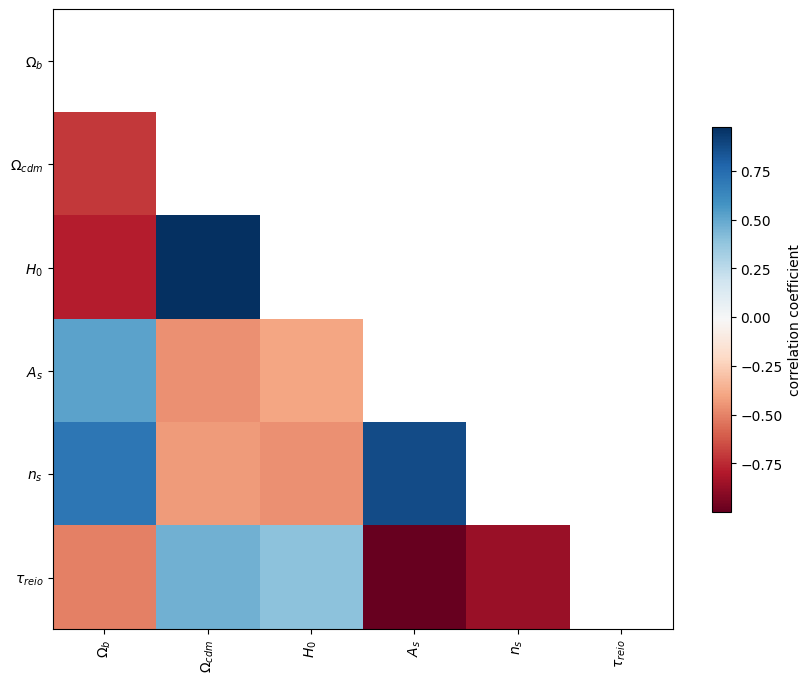

In [13]:
# plot the correlation matrix
Npars = len(fisher1)
latex_names = [r'$\Omega_b$', r'$\Omega_{cdm}$', r'$H_0$', r'$A_s$', r'$n_s$', r'$\tau_{reio}$']

fisher_sigmas = np.sqrt(np.diag(fisher1))
norm = np.outer(fisher_sigmas, fisher_sigmas)
fisher_corr = fisher1 / norm

fig, ax = plt.subplots(figsize=(10, 10))
ind = np.triu_indices_from(fisher_corr)
fisher_corr[ind] = np.nan
im = ax.imshow(fisher_corr, cmap="RdBu")
ax.set_xticks(np.arange(Npars), latex_names, rotation=90)
ax.set_yticks(np.arange(Npars), latex_names, rotation=0)
fig.colorbar(im, shrink=0.5).set_label("correlation coefficient")

In [14]:
import pandas as pd

pars, centers, half_steps, pars_dict, steps_dict, class_params, obs_params = define_params()

data = {'Parameter': pars, 'Fiducial Value': centers, 'σ': sigmas1, 'S/N': centers/sigmas1}

df = pd.DataFrame(data, index=pars)

df

,Parameter,Fiducial Value,σ,S/N
omega_b,omega_b,2.237000e-02,5.721638e-05,390.971967
omega_cdm,omega_cdm,1.200000e-01,8.416053e-04,142.584652
H0,H0,6.736000e+01,3.288778e-01,204.817707
A_s,A_s,2.100000e-09,2.410702e-11,87.111554
n_s,n_s,9.649000e-01,2.624621e-03,367.634020
tau_reio,tau_reio,5.440000e-02,6.402250e-03,8.497013


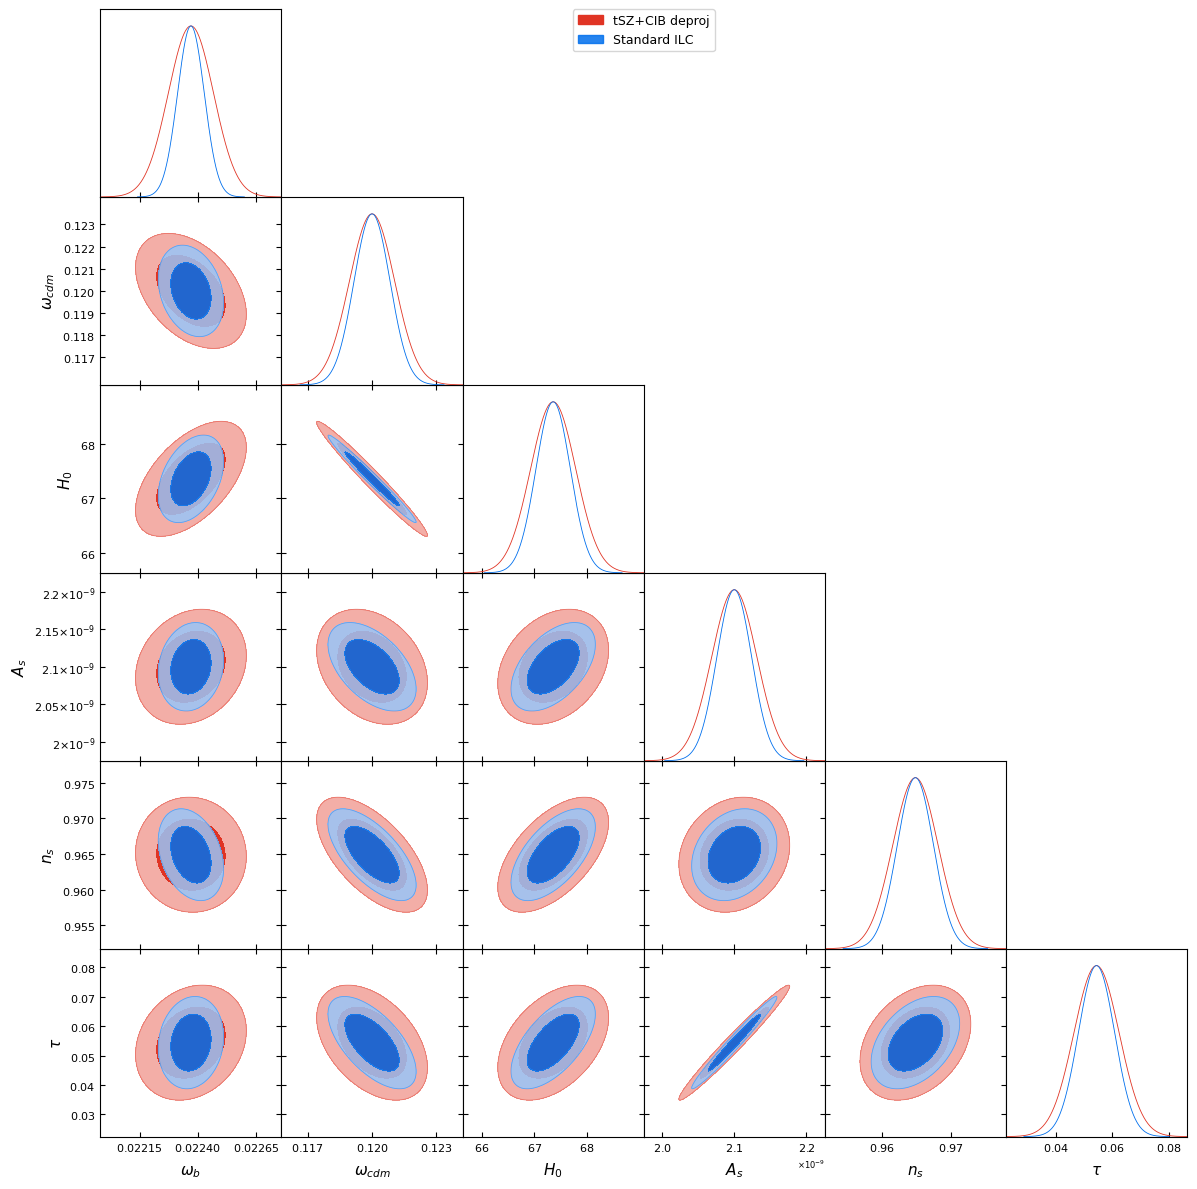

In [17]:
from getdist.gaussian_mixtures import GaussianND, Mixture2D
from getdist import plots

latex_label = ['\\omega_b', '\\omega_{cdm}', 'H_0', 'A_s', 'n_s', '\\tau']

gauss1 = GaussianND(centers, covmat1, names = pars, labels = latex_label)
gauss2 = GaussianND(centers, covmat2, names = pars, labels = latex_label)

g = plots.get_subplot_plotter()
g.triangle_plot([gauss2,gauss1], pars,filled=True, legend_labels = ['tSZ+CIB deproj','Standard ILC',])